In [2]:
import warnings
warnings.filterwarnings('ignore')

In [142]:
#패키지 로딩

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso,ElasticNet,Ridge

In [4]:
sns.set_style('whitegrid')

In [5]:
#데이터 살펴보기

house_sales = pd.read_csv('kc_house_data.csv')
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


In [6]:
house_sales

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,1410,1287


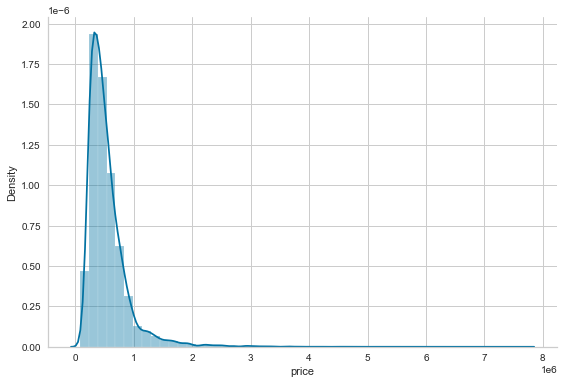

In [7]:
#Price 분포 확인

sns.distplot(house_sales.price)
sns.despine()#겉 테두리 제거
plt.tight_layout(); #겉 여백 제거

In [69]:
#train, test set 나누기

train, test = train_test_split(house_sales, train_size=0.80, test_size=0.20, random_state=2)

In [70]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=2)

In [73]:
train.shape, val.shape, test.shape

((13832, 16), (3458, 16), (4323, 16))

In [71]:
#x, y 축 나누기

X_train = train.drop('price', axis=1)
X_val = val.drop('price', axis=1)
X_test = test.drop('price', axis=1)

#Price를 log transformation, 정규분포화

y_train = np.log(train.price)
y_val = np.log(val.price)
y_test = np.log(test.price)

<AxesSubplot:xlabel='price', ylabel='Density'>

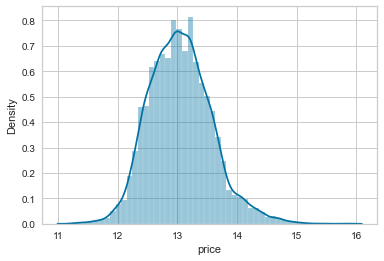

In [72]:
#분포 확인하기

sns.distplot(y_train)

In [83]:
#기준 모델

y_train.mean()

13.049164264085784

In [307]:
y_pred_basemodel = [y_train.mean()] * len(y_val)

In [308]:
print('MAE: ', mean_absolute_error(y_val, y_pred_basemodel))

MAE:  0.4064307627826552


In [75]:
#종속 변수와 독립 변수의 관계 correlation 확인하는 mutual_info_regression 사용

mi_reg = pd.Series(mutual_info_regression(X_train, y_train),
                   index=X_train.columns).sort_values(ascending=False)
mi_reg

grade            0.348420
sqft_living      0.343827
sqft_living15    0.260346
sqft_above       0.256249
bathrooms        0.208184
bedrooms         0.080603
sqft_lot15       0.077760
floors           0.077737
yr_built         0.077669
sqft_basement    0.065086
sqft_lot         0.064610
view             0.057704
waterfront       0.014397
yr_renovated     0.010362
condition        0.006184
dtype: float64

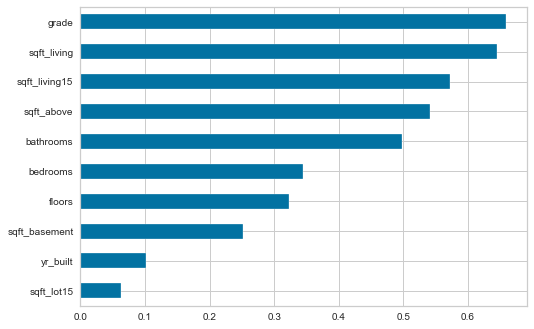

In [14]:
# Correlation과 순서가 매우 비슷함

correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

In [78]:
#관계 있는 top12만 사용

X_train = X_train.loc[:, mi_reg.iloc[:12].index]
X_val = X_val.loc[:, mi_reg.iloc[:12].index]
X_test = X_test.loc[:, mi_reg.iloc[:12].index]

In [82]:
X_train

,grade,sqft_living,sqft_living15,sqft_above,bathrooms,bedrooms,sqft_lot15,floors,yr_built,sqft_basement,sqft_lot,view
6183,7,1760,1860,1070,1.75,4,5750,1.0,1962,690,5750,2
8194,7,1030,1030,1030,1.00,3,4700,1.0,1952,0,4700,0
7076,8,2550,2340,2050,4.00,3,6400,2.0,1940,500,3900,2
5607,10,3270,3270,3270,3.25,4,6546,2.0,2001,0,6027,0
14664,7,2490,3080,1400,2.25,4,10720,1.0,1979,1090,10720,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2717,10,3070,3490,2440,2.75,3,11913,2.0,1987,630,10739,0
19935,8,1560,1560,1560,2.00,3,1728,3.0,2014,0,1020,0
115,8,4380,1830,2780,3.50,3,6350,2.0,1900,1600,6350,0
13009,7,1970,1780,1970,2.25,3,3716,2.0,1997,0,3716,0


In [86]:
#표준화

X_train_scaled = scale(X_train)

In [87]:
X_train_scaled

array([[-0.55971427, -0.34424997, -0.18703191, ...,  0.90916737,
        -0.23080316,  2.28787608],
       [-0.55971427, -1.14456012, -1.39467123, ..., -0.65785569,
        -0.25687293, -0.30668832],
       [ 0.28909264,  0.5218391 ,  0.51136192, ...,  0.47766827,
        -0.27673561,  2.28787608],
       ...,
       [ 0.28909264,  2.52809605, -0.23068152, ...,  2.97582099,
        -0.21590615, -0.30668832],
       [-0.55971427, -0.11402376, -0.30343088, ..., -0.65785569,
        -0.28130402, -0.30668832],
       [-1.40852118, -1.50634416, -1.39467123, ..., -0.65785569,
        -0.24445875, -0.30668832]])

In [88]:
#k군집 회귀 모델 실행

model = KNeighborsRegressor()
model.fit(X=X_train_scaled, y=y_train)

KNeighborsRegressor()

In [89]:
y_pred = model.predict(X_train_scaled)

In [90]:
y_pred

array([13.01233405, 12.86212724, 13.54514286, ..., 13.90759477,
       12.6847721 , 12.22167049])

In [91]:
#잔차 확인

error = (y_train - y_pred).rename('Prediction Errors')

In [92]:
error

6183     0.050279
8194    -0.054475
7076     0.260317
5607     0.046647
14664   -0.314084
           ...   
2717     0.140890
19935    0.065790
115     -0.392514
13009    0.051929
2510    -0.270490
Name: Prediction Errors, Length: 13832, dtype: float64

In [93]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error, 
                             median_absolute_error, 
                             explained_variance_score, 
                             r2_score)

In [96]:
#주요 지표 스코어 출력

scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y_train, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y_train, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y_train, y_pred=y_pred)
)

In [97]:
scores

{'rmse': 0.25826161277250165,
 'rmsle': 0.018453070130098045,
 'mean_ae': 0.19997301646144475,
 'median_ae': 0.16008726658797556,
 'r2score': 0.7612043363876682}

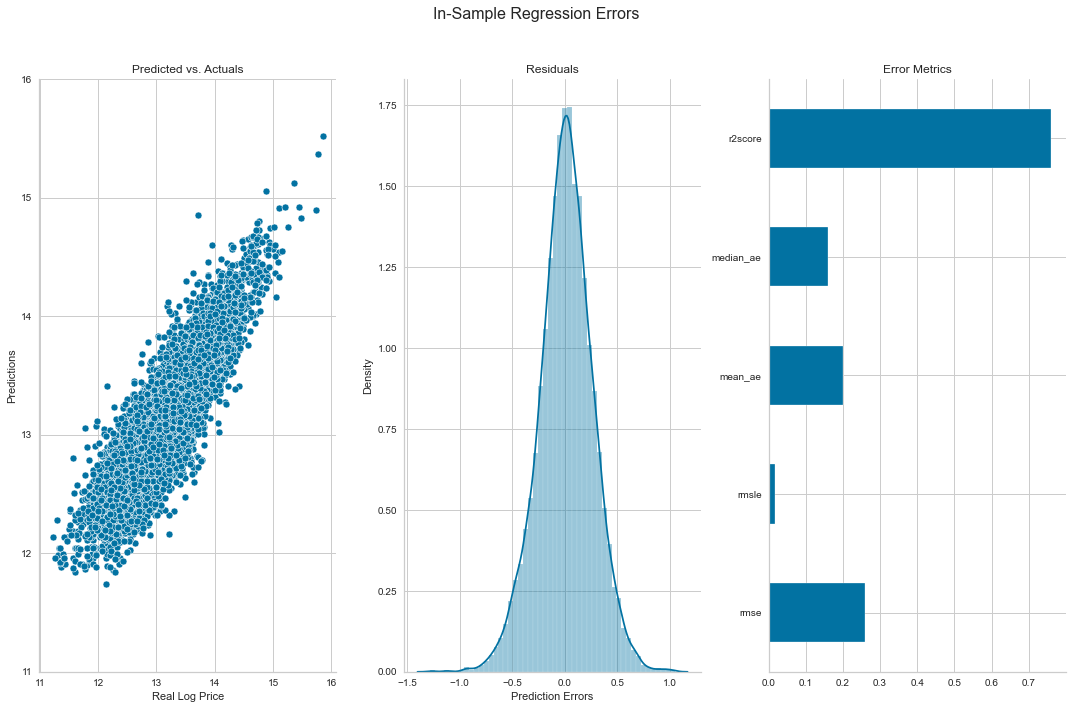

In [105]:
#확실하게 분포를 그리고 있고, 잔차도 정규분포를 그리고 있음.

fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
sns.scatterplot(x=y_train, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Real Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

In [106]:
axes

array([<AxesSubplot:title={'center':'Predicted vs. Actuals'}, xlabel='Real Log Price', ylabel='Predictions'>,
       <AxesSubplot:title={'center':'Residuals'}, xlabel='Prediction Errors', ylabel='Density'>,
       <AxesSubplot:title={'center':'Error Metrics'}>], dtype=object)

In [107]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [179]:
# 1번째 모델: k군집 회귀 pipe 생성

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

#몇개까지 이웃으로 할지 갯수 정하기

param_grid = {'knn__n_neighbors': n_neighbors}

# gridsearchcv로 최적 파라미터 찾기

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score,
#                          n_jobs=-1
                        )
estimator.fit(X=X_train, y=y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [180]:
#이웃 갯수 range

n_neighbors

(5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100)

In [181]:
best_k = estimator.best_params_

In [182]:
#최적은 5개

best_k

{'knn__n_neighbors': 5}

In [204]:
#최적 k군집 회귀 모델

y_pred = pipe1.predict(X_train)

In [205]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y_train, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y_train, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y_train, y_pred=y_pred)
)

In [206]:
#training set score

scores

{'rmse': 0.25826161277250165,
 'rmsle': 0.018453070130098045,
 'mean_ae': 0.19997301646144475,
 'median_ae': 0.16008726658797556,
 'r2score': 0.7612043363876682}

In [208]:
pipe1= estimator.best_estimator_

In [209]:
y_pred = pipe1.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Val 세트 MAE: {mae:f}')

Val 세트 MAE: 0.247101


In [210]:
scores_val = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_val, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y_val, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y_val, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y_val, y_pred=y_pred)
)

In [211]:
#value set score

scores_val

{'rmse': 0.31566571482577077,
 'rmsle': 0.022496590444089266,
 'mean_ae': 0.24710122508036303,
 'median_ae': 0.20487891650064505,
 'r2score': 0.6251933018067318}

In [187]:
estimator.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

In [188]:
estimator.best_params_

{'knn__n_neighbors': 5}

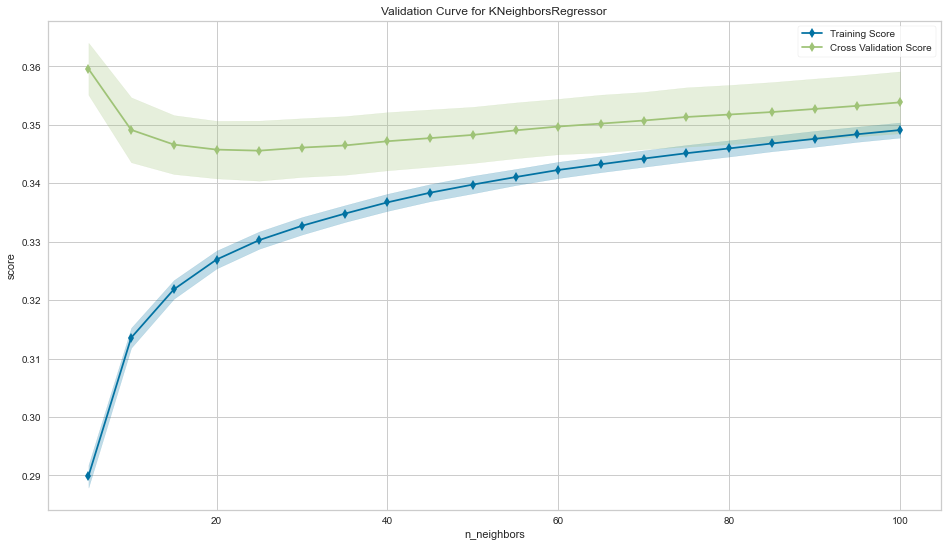

<Figure size 432x288 with 0 Axes>

In [189]:
#validation curve로 한 번 더 확인해보기

fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y)
val_curve.show()
sns.despine()
fig.tight_layout();

In [196]:
scores_cv = cross_val_score(pipe1, X_val, y_val, cv=5, 
                         scoring='neg_mean_absolute_error')


In [197]:
scores_cv

array([-0.26177532, -0.26025132, -0.26264139, -0.26069286, -0.25700506])

In [198]:
#cross validation MAE for training set

-np.mean(scores_cv)

0.26047318808666586

In [199]:
scores_r2 = cross_val_score(pipe1, X_val, y_val, cv=5, 
                         scoring='r2')


In [200]:
#cross validation R2 for training set

np.mean(scores_r2)

0.583881922525168

In [214]:
# 2번째 모델: ridge 회귀 모델 구축

pipe2 = Pipeline([('scaler', StandardScaler()), 
                 ('ridge', Ridge())])

In [274]:
#ridge alpha 범주 설정

alphas = np.arange(0.001, 1.0001, 0.0001)
ridge_parameters = {'ridge__alpha': alphas}
ridge_reg = GridSearchCV(estimator=pipe2, param_grid=ridge_parameters, scoring=rmse_score, cv=5)

In [275]:
#릿지 회귀 모델 실행

ridge_reg.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([1.000e-03, 1.100e-03, 1.200e-03, ..., 9.998e-01, 9.999e-01,
       1.000e+00])},
             scoring=make_scorer(rmse))

In [276]:
ridge_reg.best_params_

{'ridge__alpha': 0.001}

In [277]:
#최적 릿지 회귀 모델 

pipe3= ridge_reg.best_estimator_

In [278]:
y_pred = pipe3.predict(X_train)

In [279]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_train, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y_train, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y_train, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y_train, y_pred=y_pred)
)

In [280]:
#릿지회귀 training set score

scores

{'rmse': 0.3126553903639711,
 'rmsle': 0.02231652610212288,
 'mean_ae': 0.2488550269368644,
 'median_ae': 0.21118038813362539,
 'r2score': 0.6494958498915735}

In [281]:
y_pred = pipe3.predict(X_val)

In [282]:
scores_val = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_val, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y_val, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y_val, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y_val, y_pred=y_pred)
)

In [283]:
#릿지회귀 training set score

scores_val

{'rmse': 0.3113450181437484,
 'rmsle': 0.022213454811216192,
 'mean_ae': 0.2492589297064986,
 'median_ae': 0.2161089025033398,
 'r2score': 0.6339475835436215}

In [284]:
#릿지회귀 cross validation r2 score

scores_r2 = cross_val_score(pipe3, X_val, y_val, cv=5, 
                         scoring='r2')


In [388]:
#릿지회귀 cross validation mae score

scores_mae = cross_val_score(pipe3, X_val, y_val, cv=5, 
                         scoring='neg_mean_absolute_error')

In [390]:
np.mean(scores_r2)

0.630505571584348

In [393]:
-np.mean(scores_mae)

0.24997911383417706

In [286]:
pipe3

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

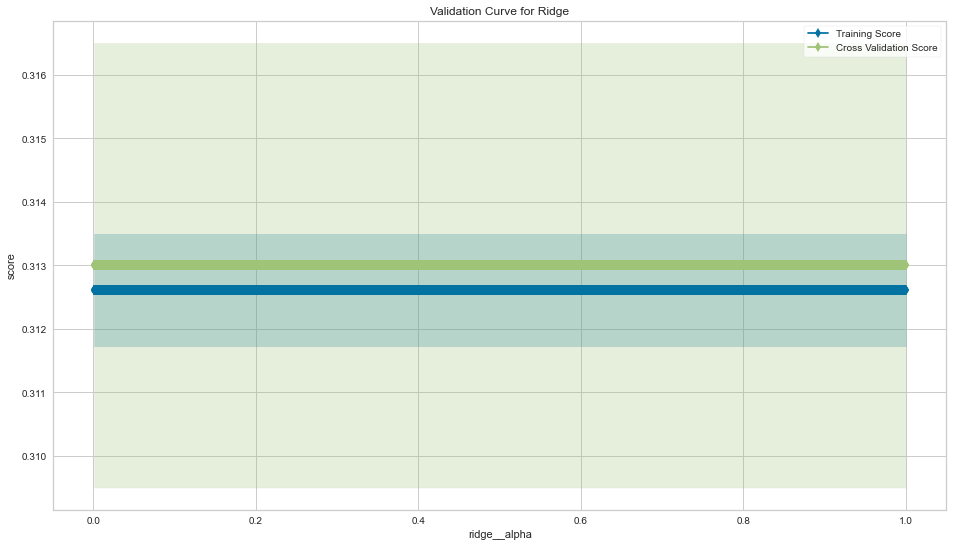

<Figure size 432x288 with 0 Axes>

In [287]:
#cross validation curve for ridge regresssion

fig, ax = plt.subplots(figsize=(16, 9))
val_curve2 = ValidationCurve(pipe3,
                      param_name='ridge__alpha',
                      param_range=alphas,
                      cv=5,
                      scoring=rmse_score,
#                       n_jobs=-1,
                      ax=ax)
val_curve2.fit(X_train, y_train)
val_curve2.show()
sns.despine()
fig.tight_layout();

In [305]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

In [311]:
#순열 중요도

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe, # model
    scoring='neg_mean_absolute_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# # permuter 계산은 preprocessing 된 X_val을 사용합니다.
# X_val_transformed = pipe.named_steps['scaler'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val, y_val);

In [312]:
#순열중요도: 군집 회귀

feature_names = list(X_val.columns)
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

grade            0.073775
yr_built         0.067459
sqft_living15    0.043629
sqft_living      0.016726
sqft_above       0.015817
bathrooms        0.014965
sqft_basement    0.014530
floors           0.011943
bedrooms         0.009857
view             0.008890
sqft_lot15       0.005649
sqft_lot         0.003520
dtype: float64

In [320]:
# 릿지회귀 계수 출력

coefficients = pipe3.named_steps['ridge'].coef_
pd.Series(coefficients, feature_names)

grade            0.247383
sqft_living      0.055062
sqft_living15    0.074984
sqft_above       0.029873
bathrooms        0.067343
bedrooms        -0.020750
sqft_lot15      -0.011534
floors           0.063001
yr_built        -0.174201
sqft_basement    0.058277
sqft_lot         0.007727
view             0.038198
dtype: float64

In [324]:
# k 군집회귀 pdpplot 출력

isolated = pdp_isolate(
    model=pipe1, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)


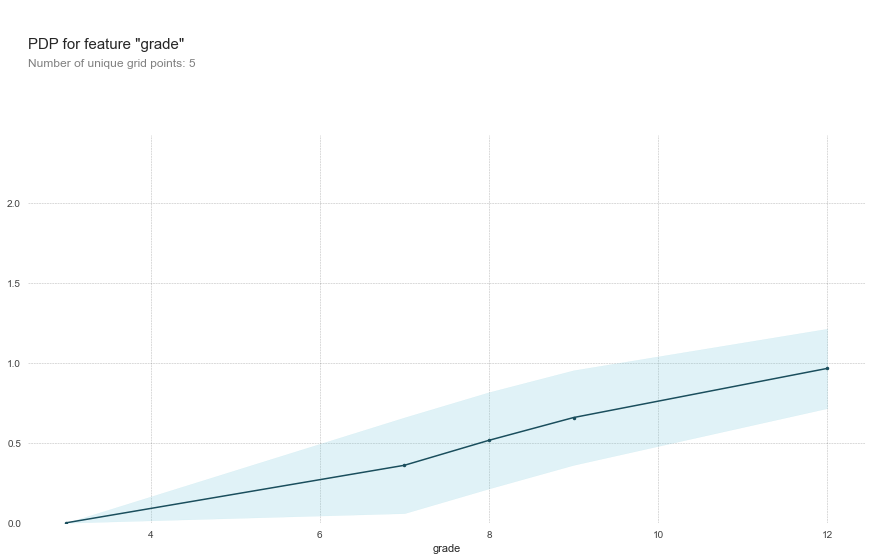

In [325]:
pdp_plot(isolated, feature_name=feature);

In [322]:
# 릿지 회귀 pdpplot 출력

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'grade'

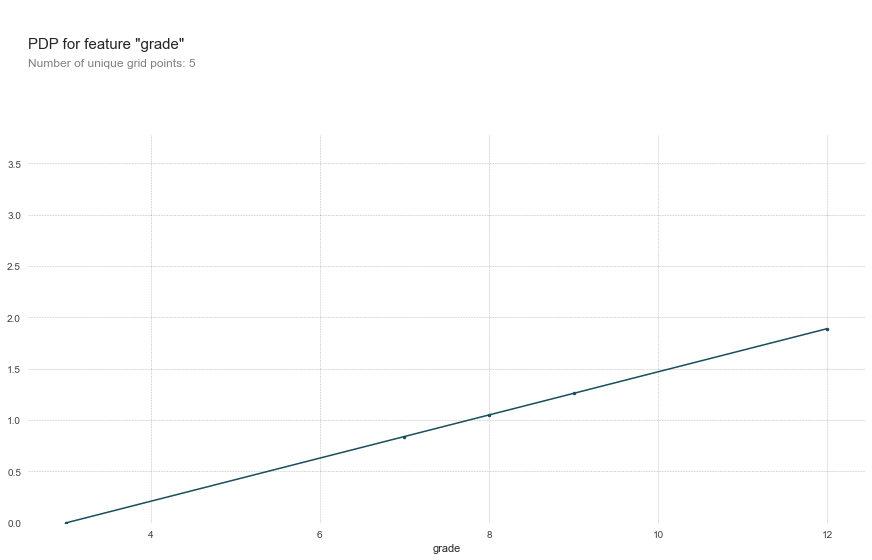

In [323]:
isolated = pdp_isolate(
    model=pipe3, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [327]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

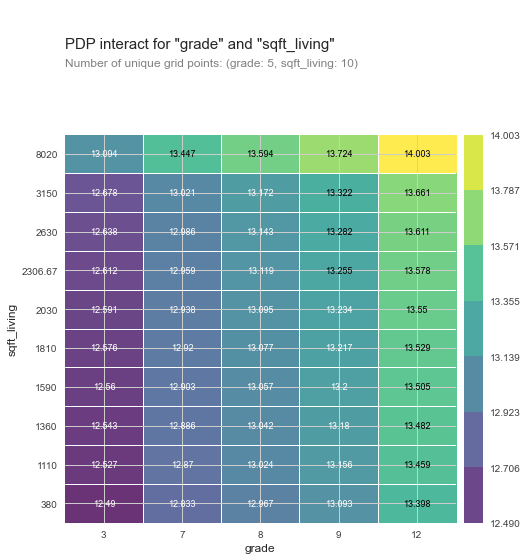

In [330]:
# 2D PDP interaction table for k군집회귀 

features = ['grade', 'sqft_living']

interaction = pdp_interact(
    model=pipe1, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [336]:
#3번째 모델: randomforest regressor 

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

pipe4 = make_pipeline(
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2))

In [338]:
#하이퍼파라미터 사용하여 찾기

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

dists = {
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe4, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [339]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.6440056983436164, 'randomforestregressor__n_estimators': 454}
MAE:  0.22046459930720386


In [341]:
#최적 랜덤포레스트 회귀모델

pipe5 = clf.best_estimator_
y_pred = pipe5.predict(X_val)

In [342]:
scores_boost = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_val, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_val, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y_val, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y_val, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y_val, y_pred=y_pred)
)

In [343]:
# 랜덤포레스트 회귀모델 score

scores_boost

{'rmse': 0.2800562411435427,
 'rmsle': 0.01998363298400014,
 'mean_ae': 0.2178866038067949,
 'median_ae': 0.17493100792771976,
 'r2score': 0.7041974242385645}

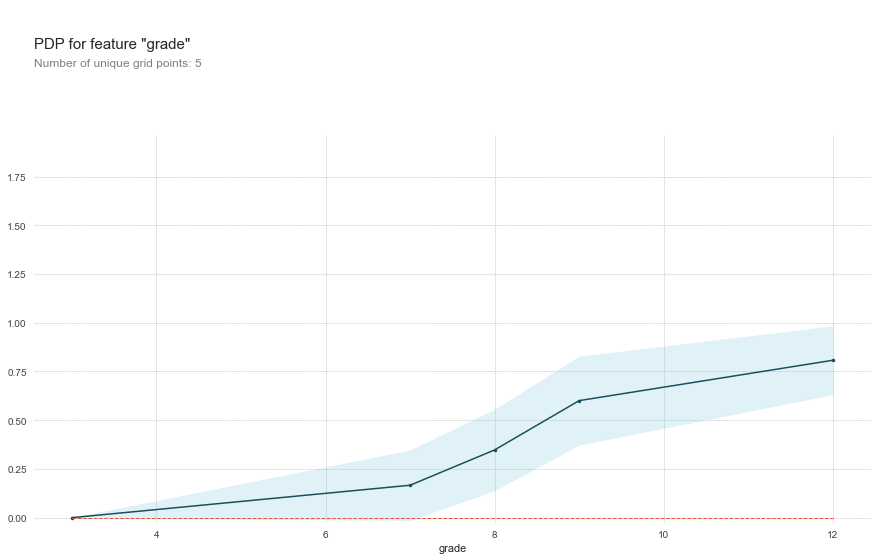

In [344]:
# 랜덤포레스트 회귀모델 pdpplot

isolated = pdp_isolate(
    model=pipe5, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [345]:
#test set에 대한 k군집회귀 score

y_pred_k_test = pipe1.predict(X_test)

In [346]:
scores_test_k = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_k_test)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_k_test)),
    mean_ae=mean_absolute_error(y_true=y_test, y_pred=y_pred_k_test),
    median_ae=median_absolute_error(y_true=y_test, y_pred=y_pred_k_test),
    r2score=explained_variance_score(y_true=y_test, y_pred=y_pred_k_test)
)

In [347]:
scores_test_k

{'rmse': 0.3103293566769058,
 'rmsle': 0.022161006899391576,
 'mean_ae': 0.24124609055184737,
 'median_ae': 0.19704066420420574,
 'r2score': 0.659601909586945}

In [354]:
#test set에 대한 릿지회귀 score

y_pred_ridge_test = pipe3.predict(X_test)

In [355]:
scores_test_ridge = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_ridge_test)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_ridge_test)),
    mean_ae=mean_absolute_error(y_true=y_test, y_pred=y_pred_ridge_test),
    median_ae=median_absolute_error(y_true=y_test, y_pred=y_pred_ridge_test),
    r2score=explained_variance_score(y_true=y_test, y_pred=y_pred_ridge_test)
)

In [356]:
scores_test_ridge

{'rmse': 0.3098757499646564,
 'rmsle': 0.02211613267846251,
 'mean_ae': 0.24531045287315345,
 'median_ae': 0.2067716042296066,
 'r2score': 0.660341658120351}

In [351]:
#test set에 대한 랜덤포레스트 score

y_pred_boost_test = pipe5.predict(X_test)

In [352]:
scores_test_boost = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_boost_test)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_boost_test)),
    mean_ae=mean_absolute_error(y_true=y_test, y_pred=y_pred_boost_test),
    median_ae=median_absolute_error(y_true=y_test, y_pred=y_pred_boost_test),
    r2score=explained_variance_score(y_true=y_test, y_pred=y_pred_boost_test)
)

In [353]:
scores_test_boost

{'rmse': 0.2768005557615933,
 'rmsle': 0.019790545177540593,
 'mean_ae': 0.21475869314718762,
 'median_ae': 0.17029072201133744,
 'r2score': 0.7289494696641403}

In [359]:
scores_test_k = -np.mean(cross_val_score(pipe1, X_test, y_test, cv=5, 
                         scoring='neg_mean_absolute_error'))


In [360]:
#test set에 대한 k군집회귀 cross validation score

scores_test_k 

0.2519933067688399

In [361]:
scores_test_ridge = -np.mean(cross_val_score(pipe3, X_test, y_test, cv=5, 
                         scoring='neg_mean_absolute_error'))

In [362]:
#test set에 대한 릿지회귀 cross validation score

scores_test_ridge

0.24625757440245052

In [363]:
scores_test_boost = -np.mean(cross_val_score(pipe5, X_test, y_test, cv=5, 
                         scoring='neg_mean_absolute_error'))

In [364]:
#test set에 대한 랜덤포레스트 cross validation score

scores_test_boost

0.22686820377483824

In [369]:
#shap model 실행

import shap

In [375]:
#2000번째 데이터 추출

row = X_test.iloc[[2000]]

In [376]:
row

,grade,sqft_living,sqft_living15,sqft_above,bathrooms,bedrooms,sqft_lot15,floors,yr_built,sqft_basement,sqft_lot,view
12839,6,1020,1600,1020,1.0,3,9700,1.0,1900,0,9147,0


In [385]:
#랜덤포레스트 모델에 대한 shap 해석

import shap

explainer = shap.TreeExplainer(pipe5[1])
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [386]:
#데이터 10개 

shap_values1 = explainer.shap_values(X_test.iloc[:10])

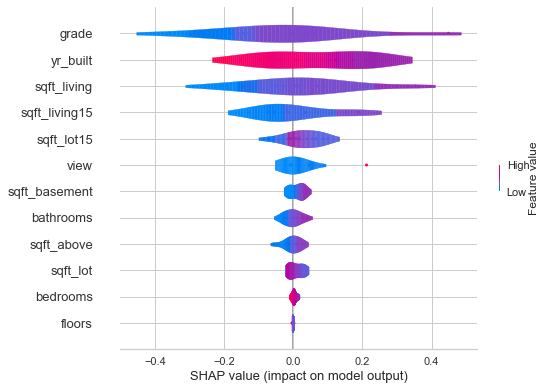

In [387]:
shap.summary_plot(shap_values1, X_test.iloc[:10], plot_type="violin")